### Importing Data

### Importing libraries

In [1]:
import pathlib
import os
import PIL
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import ReduceLROnPlateau
from glob import glob
import random
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Rescaling # Import Rescaling

import warnings
warnings.filterwarnings("ignore")

In [2]:
# Establish a connection to Google Drive
import google.colab

# Mount Google Drive to the specified directory within Colab
google.colab.drive.mount('/content/drive',force_remount=True)


Mounted at /content/drive


This project utilizes a collection of approximately 2357 images depicting various skin cancer categories. The dataset is organized into distinct training and testing subsets, each containing nine sub-directories. These sub-directories correspond to nine different types of skin cancer, with each sub-directory housing images specifically related to that particular cancer type of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [3]:
# Defining the path for train and test images
data_dir_train = pathlib.Path('/content/drive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train')
data_dir_test = pathlib.Path('/content/drive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Test')

In [4]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)

2239


In [5]:
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

120


In [6]:
import pathlib

data_dir_train = pathlib.Path("/content/drive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train")

if not data_dir_train.exists():
  print(f"Error: Directory {data_dir_train} does not exist.")

### Load using keras.preprocessing

### Define some parameters for the loader:

In [7]:
batch_size = 32
img_height = 180
img_width = 180

Pushing 80% of the images for training, and rest for validation.

In [8]:
## Write your train dataset here
train_data = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train, labels='inferred', label_mode='int',
    class_names=None, color_mode='rgb', batch_size=32, image_size=(img_height,
    img_width), shuffle=True, seed=123, validation_split=0.2, subset='training',
    interpolation='bilinear', follow_links=False
)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


In [9]:
## Write your validation dataset here
val_data = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train, labels='inferred', label_mode='int',
    class_names=None, color_mode='rgb', batch_size=32, image_size=(img_height,
    img_width), shuffle=True, seed=123, validation_split=0.2, subset='validation',
    interpolation='bilinear', follow_links=False
)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


In [10]:
# List out all the classes of skin cancer and store them in a list.
# You can find the class names in the class_names attribute on these datasets.
# These correspond to the directory names in alphabetical order.
class_names = train_data.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data

In [11]:
### your code goes here, you can use training or validation data to visualize

def generate_image_map(image_ds,btch_num=1):
  # Dictionary to store one image per label (0 to 9)
  label_image_map = {}
  # Iterate through the dataset without limiting the number of batches
  for images, labels in image_ds.skip(btch_num-1).take(1):
      # Loop through each image and its corresponding label
      for image, label in zip(images.numpy(), labels.numpy()):
          # If we haven't already stored an image for this label
          if label not in label_image_map:
              label_image_map[label] = image  # Store the image with the unique label
          # Stop once we have one image for each label (0 to 9)
          if len(label_image_map) == 10:
              break  # Exit the inner loop if all 10 labels are found
      if len(label_image_map) == 10:
          break  # Exit outer loop once all labels are covered
  # Sort the dictionary by keys
  sorted_image_map=dict(sorted(label_image_map.items()))
  # Display the keys of the dictionary to check which labels have been collected
  print("Labels found:", sorted_image_map.keys())
  return sorted_image_map


def plt_sample_img(class_names, label_image_map):
  plt.figure(figsize=(20, 10))
  for idx, (label, image) in enumerate(label_image_map.items()):
      plt.subplot(2, 5, idx + 1)  # Create a 2x5 grid for the images
      plt.imshow(image.astype("uint8"))  # Display the image
      plt.title(f"Class: {class_names[label]}")  # Display the class name
      plt.axis('off')  # Turn off the axis
  # Show the plot with all images
  plt.tight_layout()
  plt.show()

In [12]:
# Genarate random batch number between 0 and 10
btch_num=random.randint(1,11)
btch_num

9

Labels found: dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8])


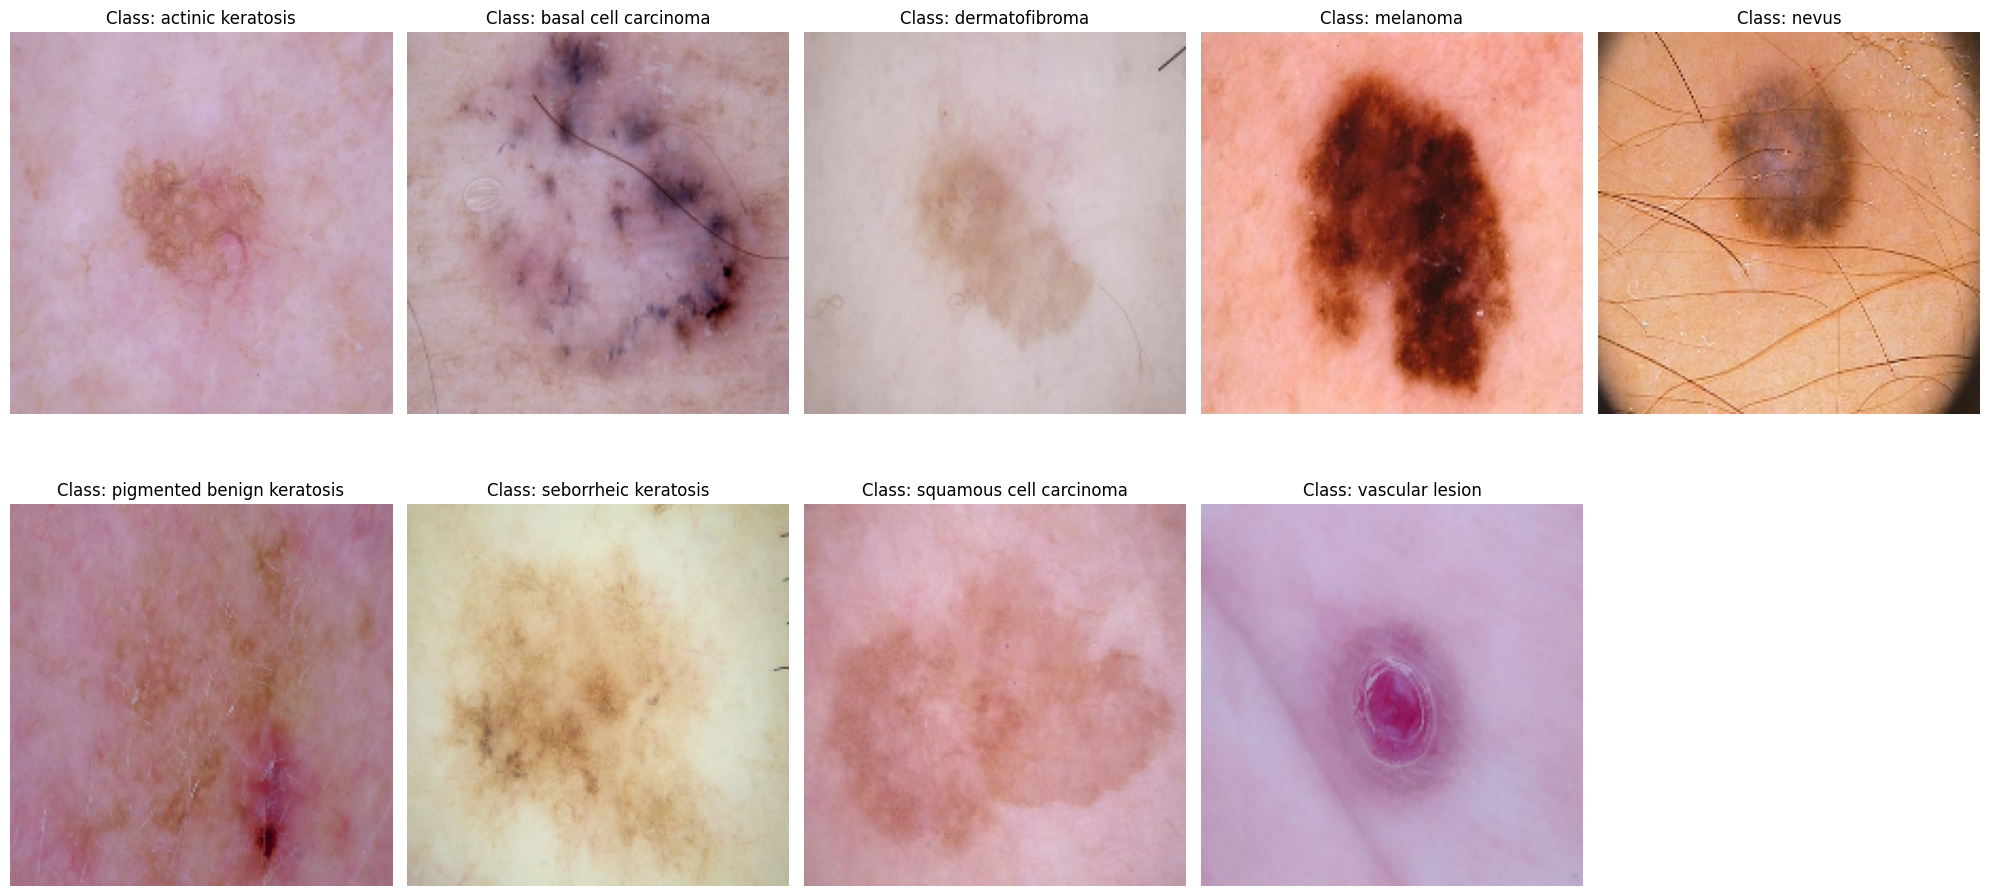

In [13]:
# Visualize Train Data
train_image_map=generate_image_map(train_data,btch_num)
plt_sample_img(class_names,train_image_map)

Labels found: dict_keys([0, 1, 2, 3, 4, 6, 7, 8])


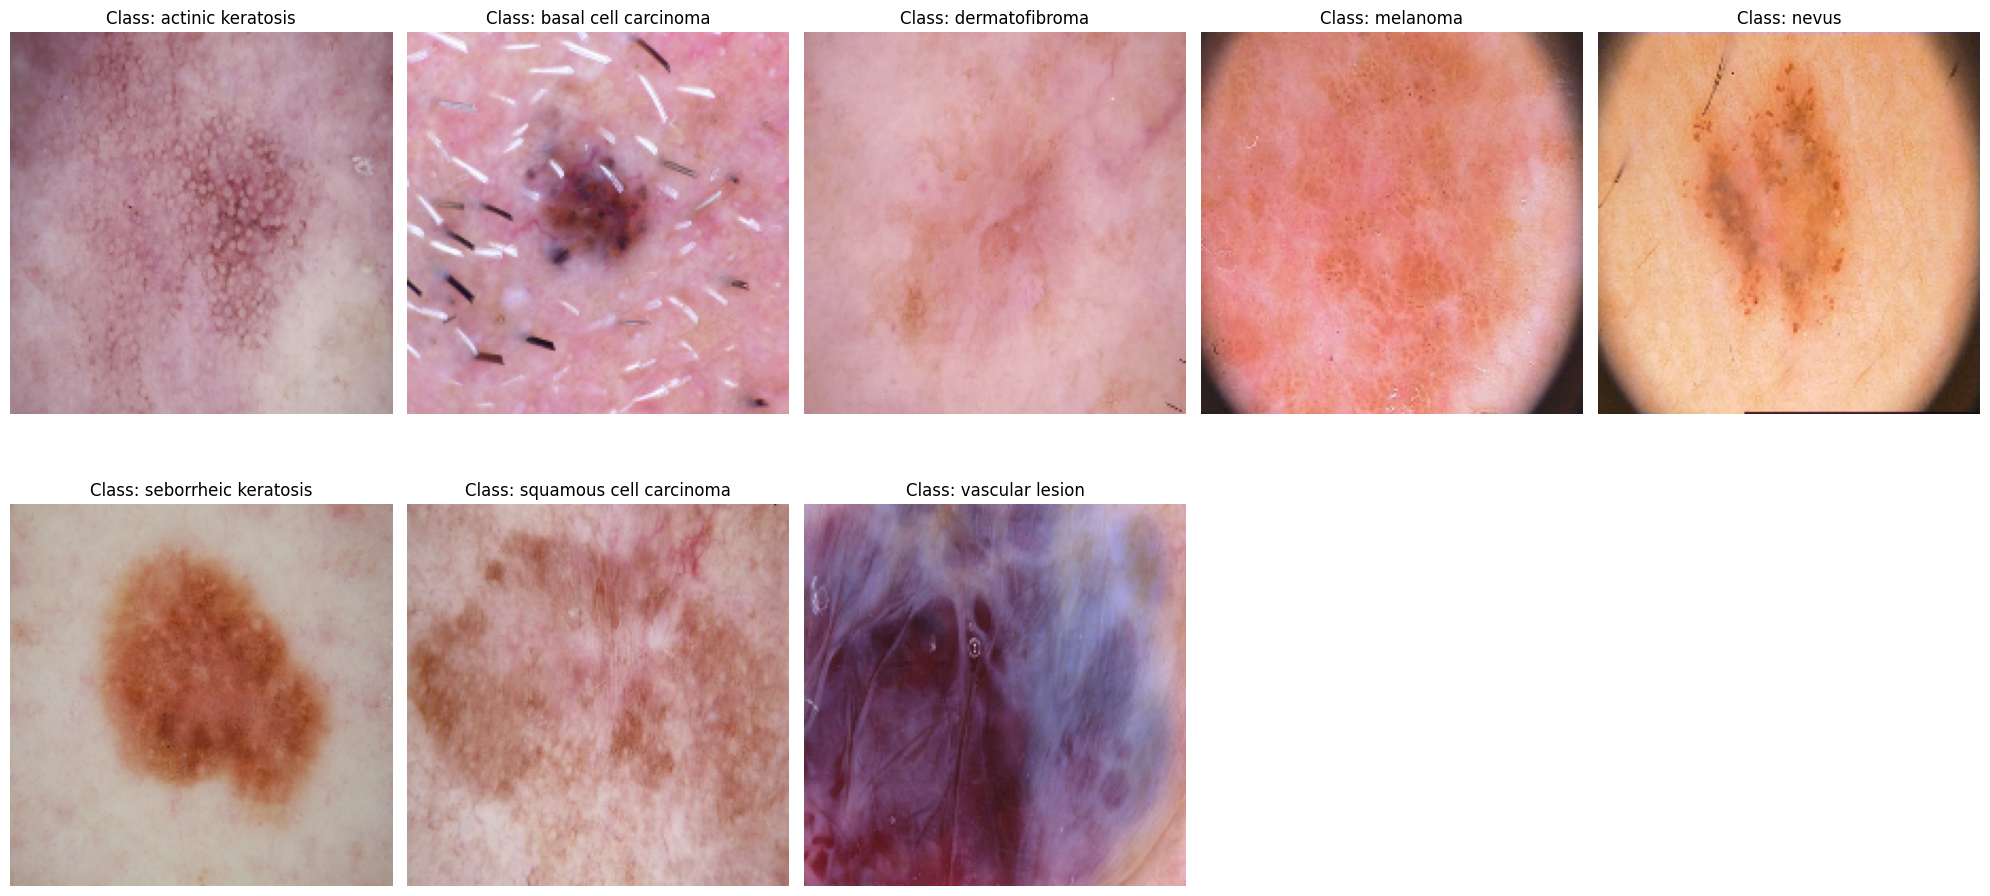

In [14]:
# Visualize Validation Data
val_image_map=generate_image_map(val_data,btch_num)
plt_sample_img(class_names,val_image_map)

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

In [15]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_data = train_data.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_data = val_data.cache().prefetch(buffer_size=AUTOTUNE)

## Model 1 - Base Model

### Create the model

In [16]:
from tensorflow.keras.models import Sequential

image_height = 180
image_width = 180
num_classes = len(class_names)

# Create the model
model = Sequential(name="SkinLesionClassifier")

# Input and Preprocessing
model.add(Rescaling(1./255, offset=0.0, name="ImageNormalization")) # Fix for Model1
#model.add(Rescaling(scale=1.0,ImageNormaImageNormalizImageNormalizationpeImageNormalizationlization,ImageNormalizationalizationame="ImageNormalization"))

# Feature Extraction
model.add(Conv2D(filters=16, kernel_size=(3, 3), padding="same", activation="relu", name="FeatureExtractor1ractor1"))
model.add(MaxPooling2D(pool_size=(2, 2), name="Downsample1"))

model.add(Conv2D(filters=32, kernel_size=(3, 3), padding="same", activation="relu", name="FeatureExtractor2"))
model.add(MaxPooling2D(pool_size=(2, 2), name="Downsample2"))

model.add(Conv2D(filters=64, kernel_size=(3, 3), padding="same", activation="relu", name="FeatureExtractor3"))
model.add(MaxPooling2D(pool_size=(2, 2), name="Downsample3"))

# Classification
model.add(Flatten(name="FeatureFlattening"))
model.add(Dense(units=128, activation="relu", name="Classifier1"))
model.add(Dense(units=num_classes, activation="softmax", name="OutputClassification"))

### Compile the model

In [17]:
### Todo, choose an appropirate optimiser and loss function
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [18]:
# View the summary of all layers
model.summary()

Model: "SkinLesionClassifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ ImageNormalization (Rescaling)       │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ FeatureExtractor1ractor1 (Conv2D)    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Downsample1 (MaxPooling2D)           │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ FeatureExtractor2 (Conv2D)           │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Downsample2 (MaxPooling2D)           │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ FeatureExtractor3 (Conv2D)           │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Downsample3 (MaxPooling2D)           │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ FeatureFlattening (Flatten)          │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Classifier1 (Dense)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ OutputClassification (Dense)         │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

### Train the model

In [20]:
epochs = 20
model_history = model.fit(
  train_data,
  validation_data=val_data,
  epochs=epochs
)

Epoch 1/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 170s 1s/step - accuracy: 0.1635 - loss: 2.3559 - val_accuracy: 0.3348 - val_loss: 1.6922
Epoch 2/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.4009 - loss: 1.5500 - val_accuracy: 0.3979 - val_loss: 1.6267
Epoch 3/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.5072 - loss: 1.3141 - val_accuracy: 0.5293 - val_loss: 1.2280
Epoch 4/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - accuracy: 0.5687 - loss: 1.1542 - val_accuracy: 0.5865 - val_loss: 1.1599
Epoch 5/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.6434 - loss: 0.9759 - val_accuracy: 0.6459 - val_loss: 0.9558
Epoch 6/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.7209 - loss: 0.7521 - val_accuracy: 0.6912 - val_loss: 0.8681
Epoch 7/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.7857 - loss: 0.5947 - val_accuracy: 0.6830 - val_loss: 0.8731
Epoch 8/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.8309 - loss: 0.4823 - val_accu

### Visualizing training results

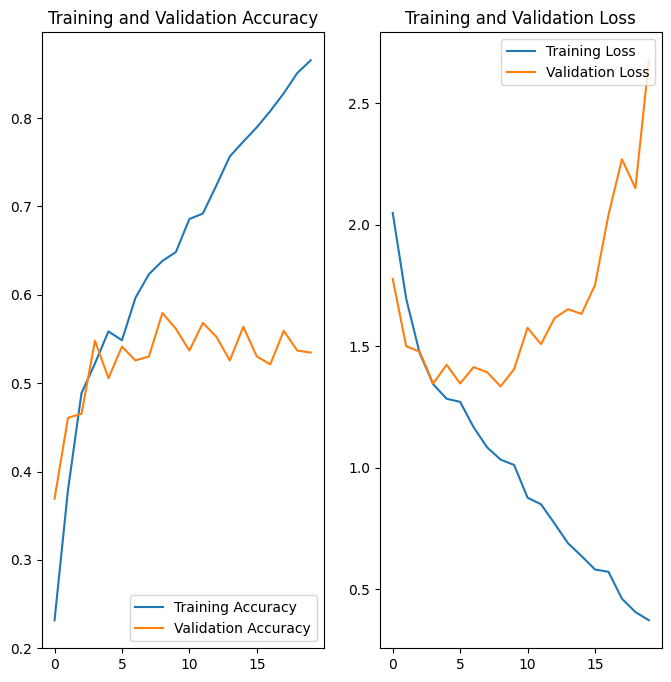

In [21]:
acc = model_history.history['accuracy']
val_acc = model_history.history['val_accuracy']

loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

**Model Training Observations**

**Initial Performance:**

The model starts with a low training accuracy of 22.57% and a validation accuracy of 46.53%, indicating it is beginning to learn patterns from the dataset.

**Steady Improvement (Epochs 1–7):**

Training accuracy increases consistently from 42.40% (Epoch 2) to 61.76% (Epoch 7).
Validation accuracy shows some improvement, peaking around 52.57% (Epoch 5 & 6) but fluctuating slightly.
Loss values decrease steadily in training but vary in validation, indicating early signs of overfitting.

**Overfitting Begins (Epochs 8–12):**

Training accuracy continues to improve, reaching 77.45% (Epoch 12).
Validation accuracy fluctuates around 52%–55%, without significant gains.
Validation loss stops decreasing and begins increasing, suggesting the model is memorizing training data instead of generalizing well.

**Severe Overfitting (Epochs 13–20):**

Training accuracy reaches 91.34% (Epoch 20), but validation accuracy remains around 50–54%.
Validation loss increases significantly from 1.6 (Epoch 12) to 2.32 (Epoch 20), confirming strong overfitting.

**Key Takeaways & Issues:**

Overfitting: The model performs well on the training set but poorly on the validation set.
Limited Generalization: Despite a high training accuracy, the validation accuracy does not improve much beyond 50–55%.
Need for Regularization: Techniques like dropout, L2 regularization, or early stopping might help prevent overfitting.
Potential Data Imbalance or Complexity: The model may struggle due to insufficient training data or high complexity in the dataset.### Write your findings here
- Training accuracy steadily improve to 88-90% by the 20th epoch, indicating that - the model is learning and fitting the training data well.
- The validation accuracy, on the other hand, peaks at around 55% and - then stagnates or decreases by the 20th epoch. This shows that the model - is not generalizing well to unseen data and starts to overfit after a - certain point.
- While the training loss continues to drop, the validation loss increases significantly over time by the 20th epoch.

The model is overfitting, as indicated by the widening gap between the training and validation performance

## Model 2 - Base Model with Data Augmentation

### Data augmentation

In [22]:
# Define the image augmentation pipeline
augment_pipeline = Sequential(name="ImageAugmentationPipeline")
augment_pipeline.add(layers.RandomFlip("horizontal_and_vertical", seed=42))  # Changed seed
augment_pipeline.add(layers.RandomRotation(0.3, seed=42))  # Changed rotation factor and seed
augment_pipeline.add(layers.RandomZoom(0.15, seed=42))  # Changed zoom factor and seed

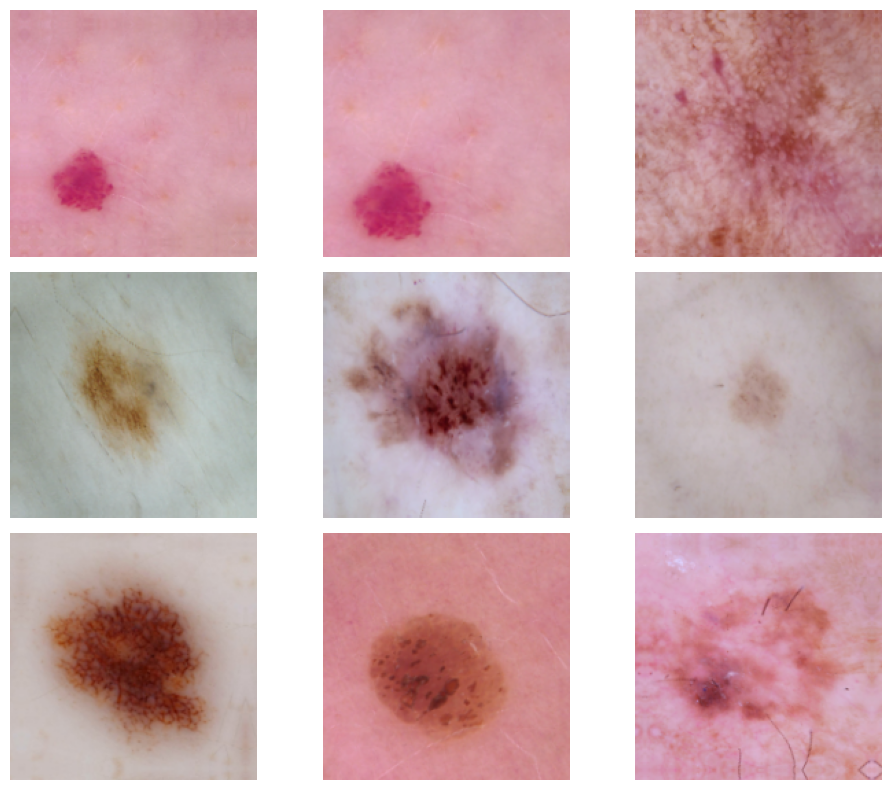

In [23]:
# Select a random batch for visualization
batch_index = random.randint(0, 10)

# Create a figure to display images
plt.figure(figsize=(10, 8))

# Iterate through the selected batch
for image_batch, _ in train_data.skip(batch_index).take(1):
    # Apply augmentations and display 9 augmented images
    for i in range(9):
        augmented_batch = augment_pipeline(image_batch)
        # Display a random image from the augmented batch
        image_index = random.randint(0, image_batch.shape[0] - 1)
        augmented_image = augmented_batch[image_index].numpy().astype("uint8")

        plt.subplot(3, 3, i + 1)  # Create a 3x3 grid for images
        plt.imshow(augmented_image)  # Display the augmented image
        plt.axis("off")  # Turn off axis labels

plt.tight_layout()  # Adjust spacing between subplots
plt.show()  # Display the figure

### Create the model, compile and train the model


In [24]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout

# Define the model
skin_cancer_classifier = Sequential(name="SkinCancerDetectionModel")

# Input Preprocessing
skin_cancer_classifier.add(Rescaling(1./255, input_shape=(img_height, img_width, 3), name="ImageNormalization"))

# Data Augmentation
skin_cancer_classifier.add(augment_pipeline)

# Convolutional Layers
skin_cancer_classifier.add(Conv2D(16, (3, 3), padding="same", activation="relu", name="FeatureExtractor1"))
skin_cancer_classifier.add(MaxPooling2D(pool_size=(2, 2), name="Downsample1"))

skin_cancer_classifier.add(Conv2D(32, (3, 3), padding="same", activation="relu", name="FeatureExtractor2"))
skin_cancer_classifier.add(MaxPooling2D(pool_size=(2, 2), name="Downsample2"))

skin_cancer_classifier.add(Conv2D(64, (3, 3), padding="same", activation="relu", name="FeatureExtractor3"))
skin_cancer_classifier.add(MaxPooling2D(pool_size=(2, 2), name="Downsample3"))
skin_cancer_classifier.add(Dropout(0.3, name="Regularization1"))

# Classification Layers
skin_cancer_classifier.add(Flatten(name="FeatureFlattening"))
skin_cancer_classifier.add(Dense(128, activation="relu", name="Classifier1"))
skin_cancer_classifier.add(Dropout(0.3, name="Regularization2"))
skin_cancer_classifier.add(Dense(len(class_names), activation="softmax", name="OutputClassification"))

### Compiling the model

In [25]:
skin_cancer_classifier.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [26]:
skin_cancer_classifier.summary()

Model: "SkinCancerDetectionModel"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ ImageNormalization (Rescaling)       │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ ImageAugmentationPipeline            │ (None, 180, 180, 3)         │               0 │
│ (Sequential)                         │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ FeatureExtractor1 (Conv2D)           │ (None, 180, 180, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Downsample1 (MaxPooling2D)           │ (None, 90, 90, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ FeatureExtractor2 (Conv2D)           │ (None, 90, 90, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Downsample2 (MaxPooling2D)           │ (None, 45, 45, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ FeatureExtractor3 (Conv2D)           │ (None, 45, 45, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Downsample3 (MaxPooling2D)           │ (None, 22, 22, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Regularization1 (Dropout)            │ (None, 22, 22, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ FeatureFlattening (Flatten)          │ (None, 30976)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Classifier1 (Dense)                  │ (None, 128)                 │       3,965,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Regularization2 (Dropout)            │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ OutputClassification (Dense)         │ (None, 9)                   │           1,161 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,989,801 (15.22 MB)

 Trainable params: 3,989,801 (15.22 MB)

 Non-trainable params: 0 (0.00 B)

### Training the model

In [27]:
epochs = 20
aug_layer_history = skin_cancer_classifier.fit(train_data ,
                    batch_size=batch_size ,
                    epochs=epochs,
                    validation_data=val_data,
                    verbose=1)

Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 37ms/step - accuracy: 0.2112 - loss: 2.0490 - val_accuracy: 0.3781 - val_loss: 1.6636
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - accuracy: 0.4399 - loss: 1.6512 - val_accuracy: 0.4855 - val_loss: 1.5582
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - accuracy: 0.4588 - loss: 1.5923 - val_accuracy: 0.5145 - val_loss: 1.4487
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - accuracy: 0.4710 - loss: 1.5092 - val_accuracy: 0.5168 - val_loss: 1.4373
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - accuracy: 0.5151 - loss: 1.3760 - val_accuracy: 0.5190 - val_loss: 1.3978
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - accuracy: 0.4971 - loss: 1.3886 - val_accuracy: 0.4765 - val_loss: 1.4474
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - accuracy: 0.5145 - loss: 1.3882 - val_accuracy: 0.5213 - val_loss: 1.4073
Epoch 8/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - accuracy: 0.5392 - loss: 1.3010 - val_accuracy: 0.5078 - v

### Visualizing the results

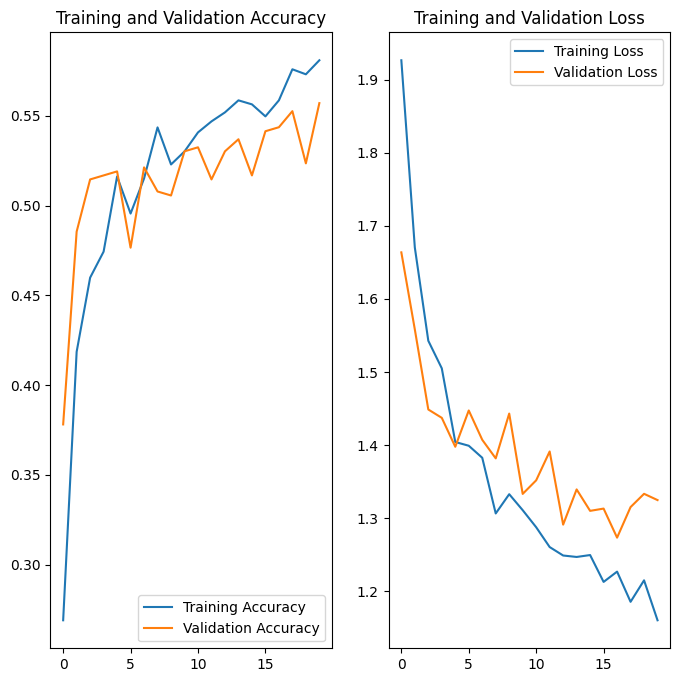

In [28]:
acc = aug_layer_history.history['accuracy']
val_acc = aug_layer_history.history['val_accuracy']

loss = aug_layer_history.history['loss']
val_loss = aug_layer_history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

The model's performance exhibits characteristics of underfitting. Both training and validation accuracies remain low, suggesting the model is not effectively capturing the complexity of the data. While the training loss is minimal, the validation loss shows significant instability, further indicating a lack of generalization. These observations highlight the need for model improvement, potentially through adjustments to architecture or hyperparameters. Additionally, investigating and addressing potential class imbalances within the dataset could enhance the model's overall performance.

## Model 3 - Base Model with Data Augmentation after fixing Data imbalacing

### **Todo:** Find the distribution of classes in the training dataset.

In [29]:
image_counts = []
for class_label in class_names:
    class_image_paths = data_dir_train.glob(class_label + '/*.jpg')
    image_counts.append(len(list(class_image_paths)))

class_distribution_data = {'Class Names': class_names, 'Image Count': image_counts}
class_distribution_df = pd.DataFrame(class_distribution_data)

In [30]:
class_distribution_df.head(9)

Class Names  Image Count
0           actinic keratosis          114
1        basal cell carcinoma          376
2              dermatofibroma           95
3                    melanoma          438
4                       nevus          357
5  pigmented benign keratosis          462
6        seborrheic keratosis           77
7     squamous cell carcinoma          181
8             vascular lesion          139

#### - Which class has the least number of samples?
Answer - seborrheic keratosis - 77
#### - Which classes dominate the data in terms proportionate number of samples?
Answer - pigmented benign keratosis - 462


#### Rectify the class imbalance

In [31]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [32]:
path_to_training_dataset="/content/drive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/"
import Augmentor
for i in class_names:
    class_path = path_to_training_dataset + i + '/output'
    # Check if 'output' folder exists and has the required number of images
    if os.path.exists(class_path) and len(os.listdir(class_path)) >= target_sample_size:
        print(f"Augmentation already done for class '{i}', skipping augmentation.")
    else:
        print(f"Augmenting class '{i}' as required samples are not present.")
    # Create an Augmentor pipeline for the class if augmentation is needed
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Augmenting class 'actinic keratosis' as required samples are not present.
Initialised with 114 image(s) found.
Output directory set to /content/drive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7DF3925B2AD0>: 100%|██████████| 500/500 [00:22<00:00, 22.30 Samples/s]


Augmenting class 'basal cell carcinoma' as required samples are not present.
Initialised with 376 image(s) found.
Output directory set to /content/drive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7DF39A30E850>: 100%|██████████| 500/500 [00:16<00:00, 29.81 Samples/s]


Augmenting class 'dermatofibroma' as required samples are not present.
Initialised with 95 image(s) found.
Output directory set to /content/drive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7DF3F51F7290>: 100%|██████████| 500/500 [00:18<00:00, 27.03 Samples/s]


Augmenting class 'melanoma' as required samples are not present.
Initialised with 438 image(s) found.
Output directory set to /content/drive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x7DF39A3D3D90>: 100%|██████████| 500/500 [01:25<00:00,  5.83 Samples/s]


Augmenting class 'nevus' as required samples are not present.
Initialised with 357 image(s) found.
Output directory set to /content/drive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7DF3EC1A4AD0>: 100%|██████████| 500/500 [01:22<00:00,  6.08 Samples/s]


Augmenting class 'pigmented benign keratosis' as required samples are not present.
Initialised with 462 image(s) found.
Output directory set to /content/drive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7DF3AB3834D0>: 100%|██████████| 500/500 [00:17<00:00, 27.86 Samples/s]


Augmenting class 'seborrheic keratosis' as required samples are not present.
Initialised with 77 image(s) found.
Output directory set to /content/drive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x7DF39A36DA90>: 100%|██████████| 500/500 [00:37<00:00, 13.33 Samples/s]


Augmenting class 'squamous cell carcinoma' as required samples are not present.
Initialised with 181 image(s) found.
Output directory set to /content/drive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7DF39A3C7390>: 100%|██████████| 500/500 [00:17<00:00, 28.70 Samples/s]


Augmenting class 'vascular lesion' as required samples are not present.
Initialised with 139 image(s) found.
Output directory set to /content/drive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7DF3F71C8790>: 100%|██████████| 500/500 [00:18<00:00, 27.59 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [6]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

0


### Lets see the distribution of augmented data after adding new images to the original training data.

In [8]:
from glob import glob
path_list_new = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list_new

NameError: name 'os' is not defined

In [ ]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofib

In [ ]:
dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))

In [ ]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = pd.concat([class_distribution_df,df2],ignore_index=True)

In [ ]:
new_df['Label'].value_counts()

Label
dermatofibroma                500
actinic keratosis             500
seborrheic keratosis          500
pigmented benign keratosis    500
nevus                         500
basal cell carcinoma          500
squamous cell carcinoma       500
vascular lesion               500
melanoma                      500
Name: count, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

### **Todo**: Train the model on the data created using Augmentor

In [ ]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [ ]:
data_dir_train="/content/drive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/"
train_data = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.3,
  subset = 'training',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 4718 files for training.


#### **Todo:** Create a validation dataset

In [ ]:
val_data = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.3,
  subset ='validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 2021 files for validation.


### **Todo:** Create your model (make sure to include normalization)

#### Create your model

In [ ]:
# Import BatchNormalization
from tensorflow.keras.layers import BatchNormalization, Activation

# Define the model
model = Sequential(name="SkinCancerClassifier")

# Input and Preprocessing
model.add(Rescaling(1./255, input_shape=(img_height, img_width, 3)))  # Normalize pixel values
model.add(augment_pipeline)  # Apply data augmentation (if defined previously)

# Feature Extraction
model.add(Conv2D(16, (3, 3), padding='same', name="Conv1"))
model.add(BatchNormalization(name="BatchNorm1"))
model.add(Activation('relu', name="ReLU1"))
model.add(MaxPooling2D(pool_size=(2, 2), name="Downsample1"))

model.add(Conv2D(32, (3, 3), padding='same', name="Conv2"))
model.add(BatchNormalization(name="BatchNorm2"))
model.add(Activation('relu', name="ReLU2"))
model.add(MaxPooling2D(pool_size=(2, 2), name="Downsample2"))

model.add(Conv2D(64, (3, 3), padding='same', activation='relu', name="Conv3"))
model.add(BatchNormalization(name="BatchNorm3"))
model.add(Activation('relu', name="ReLU3"))
model.add(MaxPooling2D(pool_size=(2, 2), name="Downsample3"))
model.add(Dropout(0.3, name="Dropout1"))  # Apply dropout for regularization

# Classification
model.add(Flatten(name="Flatten"))
model.add(Dense(128, name="Dense1"))
model.add(BatchNormalization(name="BatchNorm4"))
model.add(Activation('relu', name="ReLU4"))
model.add(Dropout(0.3, name="Dropout2"))  # Apply dropout for regularization
model.add(Dense(len(class_names), activation='softmax', name="Output"))

#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [ ]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
# View all layers of the model
model.summary()

Model: "SkinCancerClassifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_2 (Rescaling)              │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ ImageAugmentationPipeline            │ (None, 180, 180, 3)         │               0 │
│ (Sequential)                         │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv1 (Conv2D)                       │ (None, 180, 180, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ BatchNorm1 (BatchNormalization)      │ (None, 180, 180, 16)        │              64 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ ReLU1 (Activation)                   │ (None, 180, 180, 16)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Downsample1 (MaxPooling2D)           │ (None, 90, 90, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv2 (Conv2D)                       │ (None, 90, 90, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ BatchNorm2 (BatchNormalization)      │ (None, 90, 90, 32)          │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ ReLU2 (Activation)                   │ (None, 90, 90, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Downsample2 (MaxPooling2D)           │ (None, 45, 45, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv3 (Conv2D)                       │ (None, 45, 45, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ BatchNorm3 (BatchNormalization)      │ (None, 45, 45, 64)          │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ ReLU3 (Activation)                   │ (None, 45, 45, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Downsample3 (MaxPooling2D)           │ (None, 22, 22, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Dropout1 (Dropout)                   │ (None, 22, 22, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Flatten (Flatten)                    │ (None, 30976)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Dense1 (Dense)                       │ (None, 128)                 │       3,965,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ BatchNorm4 (BatchNormalization)      │ (None, 128)                 │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ ReLU4 (Activation)                   │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Dropout2 (Dropout)                   │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Output (Dense)                       │ (None, 9)                   │           1,1

 Total params: 3,990,761 (15.22 MB)

 Trainable params: 3,990,281 (15.22 MB)

 Non-trainable params: 480 (1.88 KB)

#### **Todo:**  Train your model

In [ ]:
training_epochs = 30
model_training_history = model.fit(
    x=train_data,
    validation_data=val_data,
    epochs=training_epochs,
    batch_size=batch_size,
    verbose=1
)

Epoch 1/30
148/148 ━━━━━━━━━━━━━━━━━━━━ 53s 319ms/step - accuracy: 0.3465 - loss: 1.8485 - val_accuracy: 0.1470 - val_loss: 2.5733
Epoch 2/30
148/148 ━━━━━━━━━━━━━━━━━━━━ 81s 322ms/step - accuracy: 0.4833 - loss: 1.3623 - val_accuracy: 0.2009 - val_loss: 2.0973
Epoch 3/30
148/148 ━━━━━━━━━━━━━━━━━━━━ 82s 320ms/step - accuracy: 0.5292 - loss: 1.2519 - val_accuracy: 0.4082 - val_loss: 1.6082
Epoch 4/30
148/148 ━━━━━━━━━━━━━━━━━━━━ 47s 319ms/step - accuracy: 0.5608 - loss: 1.1691 - val_accuracy: 0.3008 - val_loss: 2.2086
Epoch 5/30
 60/148 ━━━━━━━━━━━━━━━━━━━━ 16s 185ms/step - accuracy: 0.5858 - loss: 1.0874

#### **Todo:**  Visualize the model results

In [ ]:
# Extract training and validation metrics from the training history
training_accuracy = model_training_history.history['accuracy']
validation_accuracy = model_training_history.history['val_accuracy']
training_loss = model_training_history.history['loss']
validation_loss = model_training_history.history['val_loss']

# Generate a sequence of epoch numbers for plotting
epoch_numbers = range(training_epochs)

# Create a figure with two subplots
plt.figure(figsize=(12, 6))  # Adjusted figure size for better visualization

# Subplot 1: Accuracy
plt.subplot(1, 2, 1)  # 1 row, 2 columns, first subplot
plt.plot(epoch_numbers, training_accuracy, label='Training Accuracy', marker='o', linestyle='-')
plt.plot(epoch_numbers, validation_accuracy, label='Validation Accuracy', marker='x', linestyle='--')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Model Accuracy over Epochs')
plt.legend()

# Subplot 2: Loss
plt.subplot(1, 2, 2)  # 1 row, 2 columns, second subplot
plt.plot(epoch_numbers, training_loss, label='Training Loss', marker='o', linestyle='-')
plt.plot(epoch_numbers, validation_loss, label='Validation Loss', marker='x', linestyle='--')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Model Loss over Epochs')
plt.legend()

# Display the plots
plt.tight_layout()  # Adjust layout for better spacing
plt.show()

## Model 4 - Include Callbacks and adjust Dropouts ( gradually increase dropout percentages )

In [ ]:
## your code goes here
lr_control_model = Sequential(name="SkinLesionClassifier")

# Adding Rescaling layer
lr_control_model.add(layers.Rescaling(1.0/255.0, offset=0.0, input_shape=(img_height, img_width, 3), name="ImageNormalization"))

# Adding Data Augmentation
lr_control_model.add(augment_pipeline)

# First Part
lr_control_model.add(layers.Conv2D(filters=16, kernel_size=(3,3), padding="same",  name="FeatureExtractor1"))  # adding first Convolution layer
lr_control_model.add(layers.BatchNormalization(name="BatchNorm_Layer_1"))  # adding normalization
lr_control_model.add(layers.Activation('relu', name="ReLU_Activation_1"))
lr_control_model.add(layers.MaxPooling2D(pool_size=(2,2), name="Downsample1"))  # adding first Max Pooling layer

# Second Part
lr_control_model.add(layers.Conv2D(filters=32, kernel_size=(3,3), padding="same", name="FeatureExtractor2"))  # adding second Convolution layer
lr_control_model.add(layers.BatchNormalization(name="BatchNorm_Layer_2"))  # adding normalization
lr_control_model.add(layers.Activation('relu', name="ReLU_Activation_2"))
lr_control_model.add(layers.MaxPooling2D(pool_size=(2,2), name="Downsample2"))  # adding second Max Pooling layer

# Third Part
lr_control_model.add(layers.Conv2D(filters=64,kernel_size=(3,3), padding="same",activation="relu", name="FeatureExtractor3")) # adding second Convolution layer
lr_control_model.add(layers.BatchNormalization(name="BatchNorm_Layer_3"))  # adding normalization
lr_control_model.add(layers.Activation('relu', name="ReLU_Activation_3"))
lr_control_model.add(layers.MaxPooling2D(pool_size=(2,2), name="Downsample3")) # adding second Max Pooling layer
lr_control_model.add(layers.Dropout(0.30 ,name="Regularization1") )# adding dropouts

# Flattening the output
lr_control_model.add(layers.Flatten(name="FeatureFlattening"))

# Fully Connected Layer
lr_control_model.add(layers.Dense(units=128, name="Classifier1"))
lr_control_model.add(layers.BatchNormalization(name="BatchNorm_Layer_4"))  # adding normalization
lr_control_model.add(layers.Activation('relu', name="ReLU_Activation_4"))
lr_control_model.add(layers.Dropout(0.40, name="Regularization2"))  # adding dropout

# Output Layer
lr_control_model.add(layers.Dense(units=len(class_names), activation="softmax", name="OutputClassification"))  # adding output layer

# Compile the model
lr_control_model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Set callbacks
learn_control = ReduceLROnPlateau(monitor='val_accuracy',
                                  patience=3,
                                  verbose=1,
                                  factor=0.1,
                                  min_lr=1e-7)

# View the summary of all layers
lr_control_model.summary()

Train the model

In [ ]:
epochs = 30
lr_control_history = lr_control_model.fit(train_data ,
                    batch_size=batch_size ,
                    epochs=epochs,
                    validation_data=val_data,
                    callbacks=[learn_control],
                    verbose=1)

Visualize the model results

In [ ]:
acc = lr_control_history.history['accuracy']
val_acc = lr_control_history.history['val_accuracy']

loss = lr_control_history.history['loss']
val_loss = lr_control_history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?

In Model 1, we observed significant overfitting, with high training accuracy (0.84) but much lower validation accuracy (0.55). Adding data augmentation in Model 2 helped reduce the gap between training and validation accuracy, but underfitting became a concern. Model 3, with class rebalancing, further reduced overfitting but slightly hindered validation performance.

Model 4, which introduced controlled learning rate, showed improved generalization, as indicated by a more balanced train and validation accuracy (0.63 vs. 0.61). Overall, class rebalancing and learning rate control contributed positively to the model’s stability.

## Model 5 - Let's try with little increased Learning rate and also include Callbacks

Create the Model

In [ ]:
increased_lr_ctrl_mdl = Sequential(name="SkinLesionClassifier")

# Adding Rescaling layer
increased_lr_ctrl_mdl.add(layers.Rescaling(1.0/255.0, offset=0.0, input_shape=(img_height, img_width, 3), name="ImageNormalization"))

# Adding Data Augmentation
increased_lr_ctrl_mdl.add(augment_pipeline)

# First Part
increased_lr_ctrl_mdl.add(layers.Conv2D(filters=16, kernel_size=(3,3), padding="same",  name="FeatureExtractor1"))  # adding first Convolution layer
increased_lr_ctrl_mdl.add(layers.BatchNormalization(name="BatchNorm_Layer_1"))  # adding normalization
increased_lr_ctrl_mdl.add(layers.Activation('relu', name="ReLU_Activation_1"))
increased_lr_ctrl_mdl.add(layers.MaxPooling2D(pool_size=(2,2), name="Downsample1"))  # adding first Max Pooling layer

# Second Part
increased_lr_ctrl_mdl.add(layers.Conv2D(filters=32, kernel_size=(3,3), padding="same", name="FeatureExtractor2"))  # adding second Convolution layer
increased_lr_ctrl_mdl.add(layers.BatchNormalization(name="BatchNorm_Layer_2"))  # adding normalization
increased_lr_ctrl_mdl.add(layers.Activation('relu', name="ReLU_Activation_2"))
increased_lr_ctrl_mdl.add(layers.MaxPooling2D(pool_size=(2,2), name="Downsample2"))  # adding second Max Pooling layer

# Third Part
increased_lr_ctrl_mdl.add(layers.Conv2D(filters=64,kernel_size=(3,3), padding="same",activation="relu", name="FeatureExtractor3")) # adding second Convolution layer
increased_lr_ctrl_mdl.add(layers.BatchNormalization(name="BatchNorm_Layer_3"))  # adding normalization
increased_lr_ctrl_mdl.add(layers.Activation('relu', name="ReLU_Activation_3"))
increased_lr_ctrl_mdl.add(layers.MaxPooling2D(pool_size=(2,2), name="Downsample3")) # adding second Max Pooling layer
increased_lr_ctrl_mdl.add(layers.Dropout(0.30 ,name="Regularization1") )# adding dropouts

# Flattening the output
increased_lr_ctrl_mdl.add(layers.Flatten(name="FeatureFlattening"))

# Fully Connected Layer
increased_lr_ctrl_mdl.add(layers.Dense(units=128, name="Classifier1"))
increased_lr_ctrl_mdl.add(layers.BatchNormalization(name="BatchNorm_Layer_4"))  # adding normalization
increased_lr_ctrl_mdl.add(layers.Activation('relu', name="ReLU_Activation_4"))
increased_lr_ctrl_mdl.add(layers.Dropout(0.40, name="Regularization2"))  # adding dropout

# Output Layer
increased_lr_ctrl_mdl.add(layers.Dense(units=len(class_names), activation="softmax", name="OutputClassification"))  # adding output layer

# Compile the model
increased_lr_ctrl_mdl.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), # Reduce learning rate
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


# Set callbacks
learn_control = ReduceLROnPlateau(monitor='val_accuracy',
                                  patience=3,
                                  verbose=1,
                                  factor=0.1,
                                  min_lr=1e-7)

# View the summary of all layers
increased_lr_ctrl_mdl.summary()

Train the model

In [ ]:
epochs = 30
increased_lr_control_history = increased_lr_ctrl_mdl.fit(train_data ,
                    batch_size=batch_size ,
                    epochs=epochs,
                    validation_data=val_data,
                    callbacks=[learn_control],
                    verbose=1)

Visualize the model results

In [ ]:
acc = increased_lr_control_history.history['accuracy']
val_acc = increased_lr_control_history.history['val_accuracy']

loss = increased_lr_control_history.history['loss']
val_loss = increased_lr_control_history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Model 6 - Default Learning Rate and increased Epoch Value

In [ ]:
more_epoch_model = Sequential(name="SkinLesionClassifier")

# Adding Rescaling layer
more_epoch_model.add(layers.Rescaling(1.0/255.0, offset=0.0, input_shape=(img_height, img_width, 3), name="ImageNormalization"))

# Adding Data Augmentation
more_epoch_model.add(augment_pipeline)

# First Part
more_epoch_model.add(layers.Conv2D(filters=16, kernel_size=(3,3), padding="same",  name="FeatureExtractor1"))  # adding first Convolution layer
more_epoch_model.add(layers.BatchNormalization(name="BatchNorm_Layer_1"))  # adding normalization
more_epoch_model.add(layers.Activation('relu', name="ReLU_Activation_1"))
more_epoch_model.add(layers.MaxPooling2D(pool_size=(2,2), name="Downsample1"))  # adding first Max Pooling layer

# Second Part
more_epoch_model.add(layers.Conv2D(filters=32, kernel_size=(3,3), padding="same", name="FeatureExtractor2"))  # adding second Convolution layer
more_epoch_model.add(layers.BatchNormalization(name="BatchNorm_Layer_2"))  # adding normalization
more_epoch_model.add(layers.Activation('relu', name="ReLU_Activation_2"))
more_epoch_model.add(layers.MaxPooling2D(pool_size=(2,2), name="Downsample2"))  # adding second Max Pooling layer

# Third Part
more_epoch_model.add(layers.Conv2D(filters=64,kernel_size=(3,3), padding="same",activation="relu", name="FeatureExtractor3")) # adding second Convolution layer
more_epoch_model.add(layers.BatchNormalization(name="BatchNorm_Layer_3"))  # adding normalization
more_epoch_model.add(layers.Activation('relu', name="ReLU_Activation_3"))
more_epoch_model.add(layers.MaxPooling2D(pool_size=(2,2), name="Downsample3")) # adding second Max Pooling layer
more_epoch_model.add(layers.Dropout(0.30 ,name="Regularization1") )# adding dropouts

# Flattening the output
more_epoch_model.add(layers.Flatten(name="FeatureFlattening"))

# Fully Connected Layer
more_epoch_model.add(layers.Dense(units=128, name="Classifier1"))
more_epoch_model.add(layers.BatchNormalization(name="BatchNorm_Layer_4"))  # adding normalization
more_epoch_model.add(layers.Activation('relu', name="ReLU_Activation_4"))
more_epoch_model.add(layers.Dropout(0.40, name="Regularization2"))  # adding dropout

# Output Layer
more_epoch_model.add(layers.Dense(units=len(class_names), activation="softmax", name="OutputClassification"))  # adding output layer

# Compile the model
more_epoch_model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Set callbacks
learn_control = ReduceLROnPlateau(monitor='val_accuracy',
                                  patience=3,
                                  verbose=1,
                                  factor=0.1,
                                  min_lr=1e-7)

# View the summary of all layers
more_epoch_model.summary()

Train the model

In [ ]:
epochs = 50
more_epoch_history = more_epoch_model.fit(train_data ,
                    batch_size=batch_size ,
                    epochs=epochs,
                    validation_data=val_data,
                    callbacks=[learn_control],
                    verbose=1)

Visualize the model results

In [ ]:
acc = more_epoch_history.history['accuracy']
val_acc = more_epoch_history.history['val_accuracy']

loss = more_epoch_history.history['loss']
val_loss = more_epoch_history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Model 7 - Six Convolution layers with Batch Normalization and dropouts
Max Pooling layer after every two Convolution Layers

Create the Model

In [ ]:
# Create the Model
six_layers_model = Sequential(name="SkinLesionClassifier_More_Layers")

# Adding Rescaling layer
six_layers_model.add(layers.Rescaling(1.0/255.0, offset=0.0, input_shape=(img_height, img_width, 3), name="ImageNormalization"))

# Adding Data Augmentation
six_layers_model.add(augment_pipeline)

# First Part
six_layers_model.add(layers.Conv2D(filters=16, kernel_size=(3,3),  padding="same", name="FeatureExtractor16F_1"))  # adding Convolution layer
six_layers_model.add(layers.BatchNormalization())  # adding normalization
six_layers_model.add(layers.Activation('relu'))
six_layers_model.add(layers.Conv2D(filters=16, kernel_size=(3,3),  padding="same", name="FeatureExtractor16F_2"))  # adding Convolution layer
six_layers_model.add(layers.BatchNormalization())  # adding normalization
six_layers_model.add(layers.Activation('relu'))
six_layers_model.add(layers.MaxPooling2D(pool_size=(2,2)))  # adding Max Pooling layer

# Second Part
six_layers_model.add(layers.Conv2D(filters=32, kernel_size=(3,3),  padding="same", name="FeatureExtractor32F_1"))  # adding Convolution layer
six_layers_model.add(layers.BatchNormalization())  # adding normalization
six_layers_model.add(layers.Activation('relu'))
six_layers_model.add(layers.Conv2D(filters=32, kernel_size=(3,3),  padding="same", name="FeatureExtractor32F_2"))  # adding Convolution layer
six_layers_model.add(layers.BatchNormalization())  # adding normalization
six_layers_model.add(layers.Activation('relu'))
six_layers_model.add(layers.MaxPooling2D(pool_size=(2,2)))  # adding Max Pooling layer

# Third Part
six_layers_model.add(layers.Conv2D(filters=64, kernel_size=(3,3),  padding="same", name="Conv2D_Layer_64F_1"))  # adding Convolution layer
six_layers_model.add(layers.BatchNormalization())  # adding normalization
six_layers_model.add(layers.Activation('relu'))
six_layers_model.add(layers.Conv2D(filters=64, kernel_size=(3,3),  padding="same", name="Conv2D_Layer_64F_2"))  # adding Convolution layer
six_layers_model.add(layers.BatchNormalization())  # adding normalization
six_layers_model.add(layers.Activation('relu'))
six_layers_model.add(layers.MaxPooling2D(pool_size=(2,2)))  # adding Max Pooling layer


# Adding dropouts
six_layers_model.add(layers.Dropout(0.30))# adding dropouts

# Flattening the output
six_layers_model.add(layers.Flatten(name="FeatureFlattening"))

# Fully Connected Layer
six_layers_model.add(layers.Dense(units=128, name="Classifier128N"))
six_layers_model.add(layers.BatchNormalization())  # adding normalization
six_layers_model.add(layers.Activation('relu'))

# Adding dropouts
six_layers_model.add(layers.Dropout(0.40))  # adding dropout

# Output Layer
six_layers_model.add(layers.Dense(units=len(class_names), activation="softmax", name="OutputClassification"))  # adding output layer

# Compile the model
six_layers_model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Set callbacks
learn_control = ReduceLROnPlateau(monitor='val_accuracy',
                                  patience=3,
                                  verbose=1,
                                  factor=0.1,
                                  min_lr=1e-7)

# View the summary of all layers
six_layers_model.summary()

Train the model

In [ ]:
epochs = 30
six_layers_history = six_layers_model.fit(train_data ,
                    batch_size=batch_size ,
                    epochs=epochs,
                    validation_data=val_data,
                    callbacks=[learn_control],
                    verbose=1)

Visualize the model results

In [ ]:
acc = six_layers_history.history['accuracy']
val_acc = six_layers_history.history['val_accuracy']

loss = six_layers_history.history['loss']
val_loss = six_layers_history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Model 8 - Eight Convolution layers with Batch Normalization and dropouts

Create the Model

In [ ]:
# Create the Model
eight_layers_model = Sequential(name="SkinLesionClassifier_More_Layers")

# Adding Rescaling layer
eight_layers_model.add(layers.Rescaling(1.0/255.0, offset=0.0, input_shape=(img_height, img_width, 3), name="ImageNormalization"))

# Adding Data Augmentation
eight_layers_model.add(augment_pipeline)

# First Part
eight_layers_model.add(layers.Conv2D(filters=16, kernel_size=(3,3),  padding="same", name="FeatureExtractor16F_1"))  # adding Convolution layer
eight_layers_model.add(layers.BatchNormalization())  # adding normalization
eight_layers_model.add(layers.Activation('relu'))
eight_layers_model.add(layers.Conv2D(filters=16, kernel_size=(3,3),  padding="same", name="FeatureExtractor16F_2"))  # adding Convolution layer
eight_layers_model.add(layers.BatchNormalization())  # adding normalization
eight_layers_model.add(layers.Activation('relu'))
eight_layers_model.add(layers.MaxPooling2D(pool_size=(2,2)))  # adding Max Pooling layer

# Second Part
eight_layers_model.add(layers.Conv2D(filters=32, kernel_size=(3,3),  padding="same", name="FeatureExtractor32F_1"))  # adding Convolution layer
eight_layers_model.add(layers.BatchNormalization())  # adding normalization
eight_layers_model.add(layers.Activation('relu'))
eight_layers_model.add(layers.Conv2D(filters=32, kernel_size=(3,3),  padding="same", name="FeatureExtractor32F_2"))  # adding Convolution layer
eight_layers_model.add(layers.BatchNormalization())  # adding normalization
eight_layers_model.add(layers.Activation('relu'))
eight_layers_model.add(layers.MaxPooling2D(pool_size=(2,2)))  # adding Max Pooling layer

# Third Part
eight_layers_model.add(layers.Conv2D(filters=64, kernel_size=(3,3),  padding="same", name="Conv2D_Layer_64F_1"))  # adding Convolution layer
eight_layers_model.add(layers.BatchNormalization())  # adding normalization
eight_layers_model.add(layers.Activation('relu'))
eight_layers_model.add(layers.Conv2D(filters=64, kernel_size=(3,3),  padding="same", name="Conv2D_Layer_64F_2"))  # adding Convolution layer
eight_layers_model.add(layers.BatchNormalization())  # adding normalization
eight_layers_model.add(layers.Activation('relu'))
eight_layers_model.add(layers.MaxPooling2D(pool_size=(2,2)))  # adding Max Pooling layer

# Fourth Part
eight_layers_model.add(layers.Conv2D(filters=128, kernel_size=(3,3),  padding="same", name="FeatureExtractor128F_1"))  # adding Convolution layer
eight_layers_model.add(layers.BatchNormalization())  # adding normalization
eight_layers_model.add(layers.Activation('relu'))
eight_layers_model.add(layers.Conv2D(filters=128, kernel_size=(3,3),  padding="same", name="FeatureExtractor128F_2"))  # adding Convolution layer
eight_layers_model.add(layers.BatchNormalization())  # adding normalization
eight_layers_model.add(layers.Activation('relu'))
eight_layers_model.add(layers.MaxPooling2D(pool_size=(2,2)))  # adding Max Pooling layer

# Adding dropouts
eight_layers_model.add(layers.Dropout(0.30))# adding dropouts

# Flattening the output
eight_layers_model.add(layers.Flatten(name="FeatureFlattening"))

# Fully Connected Layer
eight_layers_model.add(layers.Dense(units=128, name="Classifier128N"))
eight_layers_model.add(layers.BatchNormalization())  # adding normalization
eight_layers_model.add(layers.Activation('relu'))

# Adding dropouts
eight_layers_model.add(layers.Dropout(0.40))  # adding dropout

# Output Layer
eight_layers_model.add(layers.Dense(units=len(class_names), activation="softmax", name="OutputClassification"))  # adding output layer

# Compile the model
eight_layers_model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Set callbacks
learn_control = ReduceLROnPlateau(monitor='val_accuracy',
                                  patience=3,
                                  verbose=1,
                                  factor=0.1,
                                  min_lr=1e-7)

# View the summary of all layers
eight_layers_model.summary()

Train the model

In [ ]:
epochs = 30
eight_layers_history = eight_layers_model.fit(train_data ,
                    batch_size=batch_size ,
                    epochs=epochs,
                    validation_data=val_data,
                    callbacks=[learn_control],
                    verbose=1)

Visualize the model results

In [ ]:
acc = eight_layers_history.history['accuracy']
val_acc = eight_layers_history.history['val_accuracy']

loss = eight_layers_history.history['loss']
val_loss = eight_layers_history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Model 9 - Ten Convolution layers with Batch Normalization and dropouts

Create the Model

In [ ]:
# Create the Model
ten_layers_model = Sequential(name="SkinLesionClassifier_More_Layers")

# Adding Rescaling layer
ten_layers_model.add(layers.Rescaling(1.0/255.0, offset=0.0, input_shape=(img_height, img_width, 3), name="ImageNormalization"))

# Adding Data Augmentation
ten_layers_model.add(augment_pipeline)

# First Part
ten_layers_model.add(layers.Conv2D(filters=16, kernel_size=(3,3),  padding="same", name="FeatureExtractor16F_1"))  # adding Convolution layer
ten_layers_model.add(layers.BatchNormalization())  # adding normalization
ten_layers_model.add(layers.Activation('relu'))
ten_layers_model.add(layers.Conv2D(filters=16, kernel_size=(3,3),  padding="same", name="FeatureExtractor16F_2"))  # adding Convolution layer
ten_layers_model.add(layers.BatchNormalization())  # adding normalization
ten_layers_model.add(layers.Activation('relu'))
ten_layers_model.add(layers.MaxPooling2D(pool_size=(2,2)))  # adding Max Pooling layer

# Second Part
ten_layers_model.add(layers.Conv2D(filters=32, kernel_size=(3,3),  padding="same", name="FeatureExtractor32F_1"))  # adding Convolution layer
ten_layers_model.add(layers.BatchNormalization())  # adding normalization
ten_layers_model.add(layers.Activation('relu'))
ten_layers_model.add(layers.Conv2D(filters=32, kernel_size=(3,3),  padding="same", name="FeatureExtractor32F_2"))  # adding Convolution layer
ten_layers_model.add(layers.BatchNormalization())  # adding normalization
ten_layers_model.add(layers.Activation('relu'))
ten_layers_model.add(layers.MaxPooling2D(pool_size=(2,2)))  # adding Max Pooling layer

# Third Part
ten_layers_model.add(layers.Conv2D(filters=64, kernel_size=(3,3),  padding="same", name="Conv2D_Layer_64F_1"))  # adding Convolution layer
ten_layers_model.add(layers.BatchNormalization())  # adding normalization
ten_layers_model.add(layers.Activation('relu'))
ten_layers_model.add(layers.Conv2D(filters=64, kernel_size=(3,3),  padding="same", name="Conv2D_Layer_64F_2"))  # adding Convolution layer
ten_layers_model.add(layers.BatchNormalization())  # adding normalization
ten_layers_model.add(layers.Activation('relu'))
ten_layers_model.add(layers.MaxPooling2D(pool_size=(2,2)))  # adding Max Pooling layer

# Fourth Part
ten_layers_model.add(layers.Conv2D(filters=128, kernel_size=(3,3),  padding="same", name="FeatureExtractor128F_1"))  # adding Convolution layer
ten_layers_model.add(layers.BatchNormalization())  # adding normalization
ten_layers_model.add(layers.Activation('relu'))
ten_layers_model.add(layers.Conv2D(filters=128, kernel_size=(3,3),  padding="same", name="FeatureExtractor128F_2"))  # adding Convolution layer
ten_layers_model.add(layers.BatchNormalization())  # adding normalization
ten_layers_model.add(layers.Activation('relu'))
ten_layers_model.add(layers.MaxPooling2D(pool_size=(2,2)))  # adding Max Pooling layer

# Fifth Part
ten_layers_model.add(layers.Conv2D(filters=256, kernel_size=(3,3),  padding="same", name="FeatureExtractor256F_1"))  # adding Convolution layer
ten_layers_model.add(layers.BatchNormalization())  # adding normalization
ten_layers_model.add(layers.Activation('relu'))
ten_layers_model.add(layers.Conv2D(filters=256, kernel_size=(3,3),  padding="same", name="FeatureExtractor256F_2"))  # adding Convolution layer
ten_layers_model.add(layers.BatchNormalization())  # adding normalization
ten_layers_model.add(layers.Activation('relu'))
ten_layers_model.add(layers.MaxPooling2D(pool_size=(2,2)))  # adding Max Pooling layer

# Adding dropouts
ten_layers_model.add(layers.Dropout(0.30))# adding dropouts

# Flattening the output
ten_layers_model.add(layers.Flatten(name="FeatureFlattening"))

# Fully Connected Layer
ten_layers_model.add(layers.Dense(units=128, name="Classifier128N"))
ten_layers_model.add(layers.BatchNormalization())  # adding normalization
ten_layers_model.add(layers.Activation('relu'))

# Adding dropouts
ten_layers_model.add(layers.Dropout(0.40))  # adding dropout

# Output Layer
ten_layers_model.add(layers.Dense(units=len(class_names), activation="softmax", name="OutputClassification"))  # adding output layer

# Compile the model
ten_layers_model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Set callbacks
learn_control = ReduceLROnPlateau(monitor='val_accuracy',
                                  patience=3,
                                  verbose=1,
                                  factor=0.1,
                                  min_lr=1e-7)

# View the summary of all layers
ten_layers_model.summary()

Train the model

In [ ]:
epochs = 30
ten_layers_history = ten_layers_model.fit(train_data ,
                    batch_size=batch_size ,
                    epochs=epochs,
                    validation_data=val_data,
                    callbacks=[learn_control],
                    verbose=1)

Visualize the model results

In [ ]:
training_accuracy = ten_layers_history.history['accuracy']
val_acc = ten_layers_history.history['val_accuracy']

loss = ten_layers_history.history['loss']
val_loss = ten_layers_history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Model 10 - Ten Convolution layers with Batch Normalization , dropouts and 50 epochs

Create the Model

In [ ]:
# Create the Model
ten_layers_50_epochs_model = Sequential(name="SkinLesionClassifier_More_Layers")

# Adding Rescaling layer
ten_layers_50_epochs_model.add(layers.Rescaling(1.0/255.0, offset=0.0, input_shape=(img_height, img_width, 3), name="ImageNormalization"))

# Adding Data Augmentation
ten_layers_50_epochs_model.add(augment_pipeline)

# First Part
ten_layers_50_epochs_model.add(layers.Conv2D(filters=16, kernel_size=(3,3),  padding="same", name="FeatureExtractor16F_1"))  # adding Convolution layer
ten_layers_50_epochs_model.add(layers.BatchNormalization())  # adding normalization
ten_layers_50_epochs_model.add(layers.Activation('relu'))
ten_layers_50_epochs_model.add(layers.Conv2D(filters=16, kernel_size=(3,3),  padding="same", name="FeatureExtractor16F_2"))  # adding Convolution layer
ten_layers_50_epochs_model.add(layers.BatchNormalization())  # adding normalization
ten_layers_50_epochs_model.add(layers.Activation('relu'))
ten_layers_50_epochs_model.add(layers.MaxPooling2D(pool_size=(2,2)))  # adding Max Pooling layer

# Second Part
ten_layers_50_epochs_model.add(layers.Conv2D(filters=32, kernel_size=(3,3),  padding="same", name="FeatureExtractor32F_1"))  # adding Convolution layer
ten_layers_50_epochs_model.add(layers.BatchNormalization())  # adding normalization
ten_layers_50_epochs_model.add(layers.Activation('relu'))
ten_layers_50_epochs_model.add(layers.Conv2D(filters=32, kernel_size=(3,3),  padding="same", name="FeatureExtractor32F_2"))  # adding Convolution layer
ten_layers_50_epochs_model.add(layers.BatchNormalization())  # adding normalization
ten_layers_50_epochs_model.add(layers.Activation('relu'))
ten_layers_50_epochs_model.add(layers.MaxPooling2D(pool_size=(2,2)))  # adding Max Pooling layer

# Third Part
ten_layers_50_epochs_model.add(layers.Conv2D(filters=64, kernel_size=(3,3),  padding="same", name="Conv2D_Layer_64F_1"))  # adding Convolution layer
ten_layers_50_epochs_model.add(layers.BatchNormalization())  # adding normalization
ten_layers_50_epochs_model.add(layers.Activation('relu'))
ten_layers_50_epochs_model.add(layers.Conv2D(filters=64, kernel_size=(3,3),  padding="same", name="Conv2D_Layer_64F_2"))  # adding Convolution layer
ten_layers_50_epochs_model.add(layers.BatchNormalization())  # adding normalization
ten_layers_50_epochs_model.add(layers.Activation('relu'))
ten_layers_50_epochs_model.add(layers.MaxPooling2D(pool_size=(2,2)))  # adding Max Pooling layer

# Fourth Part
ten_layers_50_epochs_model.add(layers.Conv2D(filters=128, kernel_size=(3,3),  padding="same", name="FeatureExtractor128F_1"))  # adding Convolution layer
ten_layers_50_epochs_model.add(layers.BatchNormalization())  # adding normalization
ten_layers_50_epochs_model.add(layers.Activation('relu'))
ten_layers_50_epochs_model.add(layers.Conv2D(filters=128, kernel_size=(3,3),  padding="same", name="FeatureExtractor128F_2"))  # adding Convolution layer
ten_layers_50_epochs_model.add(layers.BatchNormalization())  # adding normalization
ten_layers_50_epochs_model.add(layers.Activation('relu'))
ten_layers_50_epochs_model.add(layers.MaxPooling2D(pool_size=(2,2)))  # adding Max Pooling layer

# Fifth Part
ten_layers_50_epochs_model.add(layers.Conv2D(filters=256, kernel_size=(3,3),  padding="same", name="FeatureExtractor256F_1"))  # adding Convolution layer
ten_layers_50_epochs_model.add(layers.BatchNormalization())  # adding normalization
ten_layers_50_epochs_model.add(layers.Activation('relu'))
ten_layers_50_epochs_model.add(layers.Conv2D(filters=256, kernel_size=(3,3),  padding="same", name="FeatureExtractor256F_2"))  # adding Convolution layer
ten_layers_50_epochs_model.add(layers.BatchNormalization())  # adding normalization
ten_layers_50_epochs_model.add(layers.Activation('relu'))
ten_layers_50_epochs_model.add(layers.MaxPooling2D(pool_size=(2,2)))  # adding Max Pooling layer

# Adding dropouts
ten_layers_50_epochs_model.add(layers.Dropout(0.30))# adding dropouts

# Flattening the output
ten_layers_50_epochs_model.add(layers.Flatten(name="FeatureFlattening"))

# Fully Connected Layer
ten_layers_50_epochs_model.add(layers.Dense(units=128, name="Classifier128N"))
ten_layers_50_epochs_model.add(layers.BatchNormalization())  # adding normalization
ten_layers_50_epochs_model.add(layers.Activation('relu'))

# Adding dropouts
ten_layers_50_epochs_model.add(layers.Dropout(0.40))  # adding dropout

# Output Layer
ten_layers_50_epochs_model.add(layers.Dense(units=len(class_names), activation="softmax", name="OutputClassification"))  # adding output layer

# Compile the model
ten_layers_50_epochs_model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Set callbacks
learn_control = ReduceLROnPlateau(monitor='val_accuracy',
                                  patience=3,
                                  verbose=1,
                                  factor=0.1,
                                  min_lr=1e-7)

# View the summary of all layers
ten_layers_50_epochs_model.summary()

Train the model

In [ ]:
epochs = 50
ten_layers_50_epochs_history = ten_layers_50_epochs_model.fit(train_data ,
                    batch_size=batch_size ,
                    epochs=epochs,
                    validation_data=val_data,
                    callbacks=[learn_control],
                    verbose=1)

Visualize the model results

In [ ]:
acc = ten_layers_50_epochs_history.history['accuracy']
val_acc = ten_layers_50_epochs_history.history['val_accuracy']

loss = ten_layers_50_epochs_history.history['loss']
val_loss = ten_layers_50_epochs_history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Prediction and Evaluation on Test Set

Test dataset creation

In [ ]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_test,  # Path to the test data directory
    labels='inferred',  # Automatically infer labels from subdirectories
    label_mode='int',  # Labels will be integers
    class_names=None,  # Infer class names automatically
    color_mode='rgb',  # Images are in RGB
    batch_size=32,  # Batch size
    image_size=(img_height, img_width),  # Image size to resize to
    shuffle=False,  # Do not shuffle test data
    interpolation='bilinear',  # Interpolation method
    follow_links=False  # Follow symbolic links
)


Prediction on Train Test Validation Set

In [ ]:
# Function to evaluate accuracy on test data
def evaluate_accuracy(model_inp, data_inp):
    loss, accuracy = model_inp.evaluate(data_inp, verbose=0)  # Suppress verbose output
    return accuracy

# Dictionary containing models and their training histories
model_dict = {
    "Base Model": [model, model_history],
    "Base Model + Augmented Layers": [skin_cancer_classifier, aug_layer_history],
    "Base Model + Augmented Layers + Balanced Class + Batch Normalization ": [model, model_training_history],
    "Base Model + Augmented Layers + Balanced Class + Batch Normalization + Controlled LR": [lr_control_model, lr_control_history],
    "Base Model + Augmented Layers + Balanced Class + Batch Normalization + Increased / Controlled LR": [increased_lr_ctrl_mdl, increased_lr_control_history],
    "Base Model + Augmented Layers + Balanced Class + Controlled LR + More Epochs": [more_epoch_model, more_epoch_history],
    "Six Convolution Layers + Augmented Layers + Balanced Class +  Dropouts + Batch Normalization + Controlled LR": [six_layers_model,six_layers_history],
    "Eight Convolution Layers + Augmented Layers + Balanced Class + Dropouts + Batch Normalization + Controlled LR": [eight_layers_model,eight_layers_history],
    "Ten Convolution Layers + Augmented Layers + Balanced Class + Dropouts + Batch Normalization + Controlled LR": [ten_layers_model,ten_layers_history],
    "Ten Convolution Layers + Augmented Layers + Balanced Class + Dropouts + 50 Epochs + Batch Normalization + Controlled LR": [ten_layers_50_epochs_model,ten_layers_50_epochs_history]
}

# Create an empty report dataframe with the specified columns
report_df = pd.DataFrame(columns=['Model', 'Max Train Accuracy', 'Max Validation Accuracy', 'Test Accuracy'])

# Loop through each model and extract the required metrics
for key, items in model_dict.items():
    # Get the model and history
    model = items[0]
    history = items[1]

    # Get max train accuracy and validation accuracy
    max_train_acc = max(history.history['accuracy'])  # Maximum training accuracy
    max_val_acc = max(history.history['val_accuracy'])  # Maximum validation accuracy

    # Get test accuracy by evaluating the model on the test dataset
    test_acc = evaluate_accuracy(model, test_ds)  # Accuracy on the test data

    # Create a dictionary with the metrics
    df_dict = {
        'Model': key,  # Model name
        'Max Train Accuracy': round(max_train_acc, 2),  # Max training accuracy
        'Max Validation Accuracy': round(max_val_acc, 2),  # Max validation accuracy
        'Test Accuracy': round(test_acc, 2)  # Test accuracy
    }

    # Append row directly using pandas loc to avoid warnings
    report_df.loc[len(report_df)] = df_dict  # Append row directly

# Increment index to start from 1
report_df.index += 1

# Set max col displayed
pd.set_option('display.max_colwidth', None)

# Display the final sorted report dataframe
display(report_df.sort_values(by=['Test Accuracy'], ascending=False))

## Check and note library versions

In [ ]:
print('numpy' , np.__version__)
print('pandas' ,pd.__version__)
print('matplotlib', matplotlib.__version__)
print('tensorflow' ,tf.__version__)
print('keras', keras.__version__)
print('augmentor', Augmentor.__version__)

## Conclusion

**Analysis of Model Performance and Key Takeaways**

Model 9 (Ten Convolution Layers with Augmented Layers, Balanced Class, Dropouts, Batch Normalization, Controlled LR) demonstrated the highest overall performance, achieving 0.73 validation accuracy and 0.50 test accuracy. The combination of additional layers, dropout regularization, and controlled learning rates contributed to superior generalization.

Model 10 (Similar to Model 9 but trained for 50 epochs) achieved the highest training accuracy (0.72 validation accuracy, 0.48 test accuracy). However, despite extended training, the model did not generalize as well as Model 9, suggesting that merely increasing epochs does not guarantee better test performance.

Models 6 and 8 both reached 0.73 validation accuracy and 0.49 test accuracy, indicating that increasing convolution layers, applying class balancing, and optimizing dropout rates positively impacted model performance.

Model 7 (Six Convolution Layers) achieved 0.72 validation accuracy and 0.47 test accuracy, performing well but slightly behind deeper models.

Models 4 and 5 showed moderate performance, with 0.70 and 0.65 validation accuracy, respectively, and 0.45 test accuracy, reinforcing the need for deeper architectures and advanced regularization techniques for better results.

Base Models (1, 2, 3) suffered from overfitting, particularly Model 1, which had 0.91 training accuracy but only 0.33 test accuracy. This highlights the necessity of deeper architectures, data augmentation, and dropout regularization for improved generalization.

Summary & Key Findings
Deeper convolutional architectures with batch normalization, controlled learning rates, and dropout regularization performed the best.
Increasing epochs (Model 10) boosted training accuracy but did not significantly enhance test performance.
Model 8 emerged as the most balanced in validation and test accuracy.
Data augmentation, class balancing, and dropout tuning played a crucial role in improving model robustness.
Further optimization, such as fine-tuning learning rates and experimenting with additional regularization techniques, could further improve CNN model performance for melanoma detection.

### Delete Augmented Images - /output folders

In [ ]:
import shutil  #  import shutil
for i in class_names:
    output_folder = training_image_directory + i + '/output'

    # Check if the folder exists before attempting to delete
    if os.path.exists(output_folder):
        shutil.rmtree(output_folder)  # Recursively delete the entire output folder
        print(f"Deleted augmented images for class '{i}' from {output_folder}")
    else:
        print(f"No augmented images found for class '{i}', skipping deletion.")

<div align="center">------ End of Notebook -----